# FUNCTION INTERPOLATION

The goal of this notebook is to have a file where the clear differences between various interpolations studied in the course on numerical approximation during the academic year 23/24 can be seen. The interpolations we will cover are:
    
1. Lagrange Interpolation.
    1. Lagrange Basis.
    2. Newton Basis.
2. Hermite Interpolation.
3. Piecewise Interpolation.
    1. Lagrange Interpolation.
    2. Splines.
        1. Natural.
4. Extra: Universal Approximation Theorem.

## Lagrange Interpolation.
Lagrange interpolation is the one in which only the data pairs interpolation points-function value are available. That is, for $n+1$ distinct points $\{x_i\}_{i=0}^n$, their respective values $\{f_i\}_{i=0}^n$ are known. 
To achieve this interpolation we define the Lagrange basis as: $$L_j(x) = \prod_{i=0, j\neq i}^n \frac{x-x_i}{x_j-x_i}.$$ Thus, for the points $\{(x_i, f_i)\}_{i=0}^n$ the Lagrange interpolating polynomial is given by: $$L_n^{x_0,...,x_n}(f)(x) = \sum_{j=0}^n L_j(x) \cdot f_j$$

We define functions for the Lagrange basis and the interpolator itself.


In [22]:

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import pandas as pd

# The functions accept:
    # x: point where interpolation is desired (symbolic or numeric)
    # y: list of points for interpolation
    # f: list of function values to interpolate
    # f_ex: known function in numeric format for evaluation
    # a: lower limit of the interval
    # b: upper limit of the interval

def baselag(x, y, puntoj):  # we calculate the j-th term of the Lagrange basis
    prod = 1
    z = sp.symbols('z')
    for puntoi in y:
        if puntoj != puntoi:
            prod *= (z - puntoi) / (puntoj - puntoi)

    if not isinstance(x, sp.Basic):  # Check if x is not symbolic by checking if it is a basic instance of the sympy module
        sust = {z: x}
        return prod.subs(sust)
    else:
        return prod.subs(z, x)

def lagrange(x, y, f):    # we calculate the Lagrange polynomial
    nodos = list(zip(y, f))
    pol = 0
    for puntos, valor in nodos:
        pol += valor * baselag(x, y, puntos)
    
    return sp.expand(pol)

def er_lagrange(x, y, f, f_ex, a, b):  # we calculate the error of the interpolator
    pol = sp.lambdify(x, lagrange(x, y, f))
    mallado = np.linspace(a, b, 10**6)

    vals = pol(mallado)
    vals_ex = f_ex(mallado)
    e_abs = max(abs(vals - vals_ex))
    return e_abs




### Example 
Suppose the function $f(x) = e^{x} + \sin(2x)$ and a mesh of equispaced points with 5 points in the interval [-2,2].


The Interpolating Polynomial is:  -0.308985633925871*x**3 + 0.712018156229999*x**2 + 2.67097149197303*x + 0.914123066163634 
 And the committed error is:  0.8614009817731478


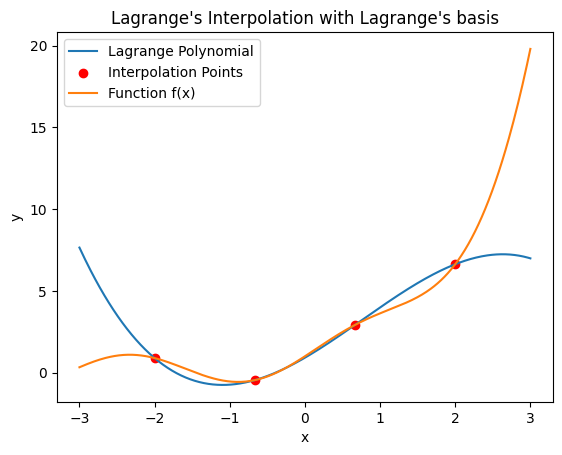

In [23]:

x = sp.symbols('x')
f = sp.exp(x) + sp.sin(2*x)
f = sp.lambdify(x, f)

# Interpolation points
a = -2
b = 2
puntos = np.linspace(a, b, 4)
valores = f(puntos)

# Obtain the Lagrange polynomial
polinomio = lagrange(x, puntos, valores)
error = er_lagrange(x, puntos, valores, f, a, b)
print('The Interpolating Polynomial is: ', polinomio, '\n And the committed error is: ', error)

# Plot the result
polinomio_eval = sp.lambdify(x, polinomio, 'numpy') # evaluate the polynomial

# Generate x values for the plot
x_vals = np.linspace(a - 1, b + 1, 400)
y_vals = polinomio_eval(x_vals)

# Plot the polynomial and the interpolation points
plt.plot(x_vals, y_vals, label='Lagrange Polynomial')
plt.scatter(puntos, valores, color='red', label='Interpolation Points')
plt.plot(x_vals, f(x_vals), label='Function f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lagrange\'s Interpolation with Lagrange\'s basis')
plt.legend()
plt.show()


Lagrange interpolation is one where only the pairs of data points interpolation-value of the function are available. That is, for $n+1$ points $\{x_i\}_{i=0}^n$, their respective values $\{f_i\}_{i=0}^n$ are known. Similarly, we can define the Newton basis as:

$$N_0(x)=1,\quad N_j(x)=\prod_{i=0}^{j-1}(x-x_i), \qquad j=1,...,n .$$

Thus, for the points $\{(x_i,f_i)\}_{i=0}^n$, the Lagrange interpolating polynomial is given by:

$$L_n^{x_0,...,x_n}(f)(x)=\sum_{j=0}^n N_j(x)\cdot f[x_0,...,x_i]$$

And the interpolator:

$$f[x_0,...,x_n]=\frac{f[x_1,...,x_n]-f[x_0,...,x_{n-1}]}{x_n-x_0},\qquad f[x_i]=f(x_i) \quad \forall i=0,...,n$$

**Note that we always use distinct points. To calculate the divided differences, we will use their generalization. That is, we define the divided differences as:**

### Generalized Divided Differences.
Let $n \in \mathbb{N}$, $f \in C^n[a, b]$ and $x_0, \ldots, x_n \in [a, b]$ be $n + 1$ points (not necessarily distinct), then:

$$
f[x_0, ..., x_n] = 
\begin{cases} 
(D_{x_0} \ldots D_{x_{n-1}} f)(x_n) & n > 0 \\
f(x_0) & n = 0 
\end{cases}
$$

Where,
$$D_c(f(x))=\frac{f(x)-f(c)}{x-c} \qquad \forall c\neq x \in [a,b]\qquad \text{and if} \quad x=c \quad D_c(f(x))=f'(c)$$


In [24]:
#Inputs:
    #x: interpolation nodes, they cannot be ordered. This means, we could have [x0,x1,x0,x1,x2,x3,...]
    #f: f values with  derivative values too. This means, [f0, f1, f'0,f'1,f2,f3,...]
#Outputs:
    #A: Difference divided generalised matrix
    #v: diag(A)

def difdivgen(x,f):

    I=np.argsort(x) # order de x and f values
    x=np.array(x)[I]
    f=np.array(f)[I]

    m=len(x)
    A=np.zeros((m,m))

    a=x[0]
    j=0
    
    #First column we dont want to have derivative values
    for i in range(m):
        if x[i]==a: #check repeated x values
            A[i][0]=f[j]
        else:
            j=i
            a=x[j] #update and check if we have derivative in x[j]
            A[i][0]=f[j]

    #Other columns
    for j in range(1,m):
        a=x[j]
        ff=f[x==a] #unique values (f,f',f'',...) for each x
        for i in range(j,m):
            if x[i]==x[i-j]:
                A[i,j]=ff[j]/mt.factorial(j)
            else:
                A[i,j]=(A[i,j-1]-A[i-1,j-1])/(x[i]-x[i-j])
                a=x[i]
                ff=f[x==a]

    v=np.diagonal(A)
    return v, A
        



**Note that if we don't have repeated values in the vector x, the if statement would never be entered, and therefore, we would calculate the divided differences in the usual manner.**

Now let's create a function for Lagrange interpolation using the Newton basis and use the previous example to verify that it does the same.


In [25]:
# #Input:
#     # x: interpolation nodes
#     # f: interpolation values
#     # y: sym or num variable

# #Output:
#     # p: polynomial

def newton(y,x,f):
    z=sp.symbols('z')
    
    v,A=difdivgen(x,f)
    n=len(x)

    x, I = np.sort(x), np.argsort(x)
    f = np.array(f)[I] 

    N=1;    #Newton base
    p=v[0]  #indepent term of polynomial

    for j in range(1,n):
        N*=z-x[j-1]
        p+=v[j]*N
        
    if isinstance(y,sp.Basic):
        return p.subs(z,y),A, v
    else:
        p_eval=sp.lambdify(z,p)
        p=p_eval(y)
        return p,A,v



def er_newton(y,x,f,f_ex,a,b):  #calc for the error of our interpolator
    mallado=np.linspace(a,b,10**6)
    pol,_,_=newton(y,x,f)
    
    if isinstance(pol,sp.Basic):
        pol=sp.lambdify(y,pol,"numpy")

    vals = pol(mallado)  
    vals_ex=f_ex(mallado)
    e_abs=max(abs(vals-vals_ex))
    return e_abs

## Same example as before
Now, we are using the Newton's basis and we can check that we are obtaining the same polynomial

The matrix is:
           0         1         2         3
0  0.892138  0.000000  0.000000  0.000000
1 -0.458521 -1.012994  0.000000  0.000000
2  2.919672  2.533645  1.329989  0.000000
3  6.632254  2.784436  0.094047 -0.308986 
 With a polynomial  -1.01299392065645*x - 0.308985633925871*(x - 0.666666666666667)*(x + 0.666666666666667)*(x + 2.0) + 1.32998942408174*(x + 0.666666666666667)*(x + 2.0) - 1.13385006276835 
 Uncertainty of: 0.8614009817731327


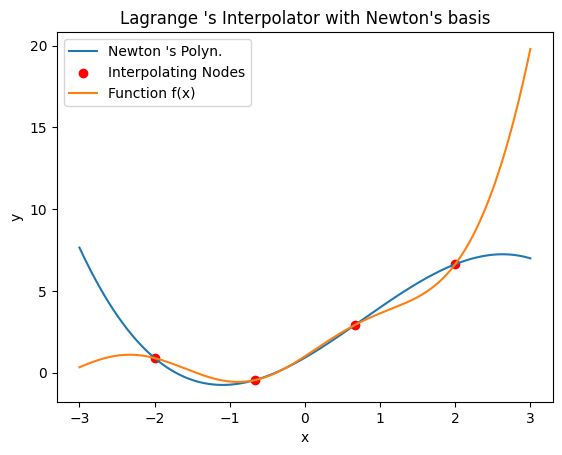

In [26]:

x =sp.symbols('x')
f=sp.exp(x)+sp.sin(2*x)
f=sp.lambdify(x,f)

#Interpolation nodes
a=-2
b=2
puntos = np.linspace(a,b,4)
valores= f(puntos)

#Polynomial and error
pol,A,_= newton(x, puntos, valores)
error= er_newton(x,puntos, valores,f,a,b)

print('The matrix is:\n', pd.DataFrame(A),'\n With a polynomial ', pol, '\n Uncertainty of:', error)

#Graphing
polinomio_eval= sp.lambdify(x, pol) 

x_vals = np.linspace(a - 1, b + 1, 400)
y_vals = polinomio_eval(x_vals)


plt.plot(x_vals, y_vals, label='Newton \'s Polyn.')
plt.scatter(puntos, valores, color='red', label='Interpolating Nodes')
plt.plot(x_vals,f(x_vals),label= 'Function f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lagrange \'s Interpolator with Newton\'s basis')
plt.legend()
plt.show()

## Hermite Interpolation
The difference with the previous interpolation is that now we will have the data of the first derivative. We can define the interpolation in a way similar to Newton's interpolation. \\

Let $ n \in \mathbb{N} ,  f \in C^K[a, b] ,  x_0, \ldots, x_n \in [a, b] , n + 1 $ distinct points with distinct associated values $ m_i \in \mathbb{N} $, and $ K \geq \max_{0 \leq i \leq n} \{m_i\} $. Then we define the polynomial of degree $ N = m_n + \sum_{i=0}^{n-1} (m_i + 1) $.

$$
N^{x_0, \ldots, x_n}_{m_0, \ldots, m_n}(f)(x) = f[x_0] + f[x_0, x_0](x - x_0) + \ldots + f[x_0, \ldots, x_0](x - x_0)^{m_0} +
$$
$$
+ f[x_0, \ldots, x_0, x_1](x - x_0)^{m_0+1} + f[x_0, \ldots, x_0, x_1, x_1](x - x_0)^{m_0+1}(x - x_1) + \ldots +
$$
$$
+ \ldots + f[x_0, \ldots, x_0, x_1, \ldots, x_1](x - x_0)^{m_0+1}(x - x_1)^{m_1+1} + \ldots + f[x_0, \ldots, x_0, \ldots, x_n, \ldots, x_n](x - x_n)^{m_n} \prod_{i=0}^{n-1}(x - x_i)^{m_i+1}
$$

Therefore, we can use the functions *newton* and *difdivgen*.


### Same example as before but now we have derivative data

          0         1         2         3         4         5
0  0.892138  0.000000  0.000000  0.000000  0.000000  0.000000
1 -0.458521 -1.012994  0.000000  0.000000  0.000000  0.000000
2 -0.458521  0.983892  1.497665  0.000000  0.000000  0.000000
3  2.919672  2.533645  1.162314 -0.125756  0.000000  0.000000
4  2.919672  2.418209 -0.086577 -0.936668 -0.304092  0.000000
5  6.632254  2.784436  0.274670  0.135468  0.402051  0.176536 
 The diagonal is: [ 0.89213778 -1.01299392  1.49766464 -0.12575641 -0.30409186  0.17653568]

 The polynomic interpolator is:  0.176535677840636*x**5 + 0.0489794935701706*x**4 - 1.09358864655092*x**3 + 0.494331518140352*x**2 + 2.98481269702305*x + 1.00119772139949 
 With an uncertainty: 0.1927900823025126


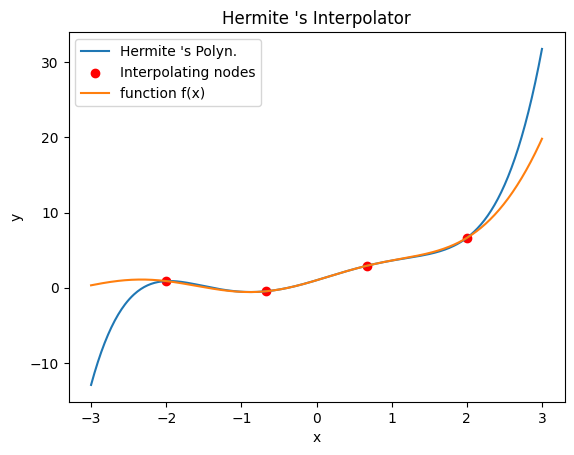

In [27]:
# Define symbolic variable and function
x = sp.symbols('x')
f = sp.exp(x) + sp.sin(2 * x)

# Define derivatives and lambdified functions
f_deriv = sp.lambdify(x, sp.diff(f, x))
f = sp.lambdify(x, f)

# Interpolating nodes
a = -2
b = 2
puntos = np.linspace(a, b, 4)
valores = np.array(f(puntos))
valores_dif = np.array(f_deriv(puntos[1:3]))

#lists for Hermite interpolation
puntos_dif = np.concatenate([puntos, puntos[1:3]])
valores_dif = np.concatenate([valores, valores_dif])



pol_Hermite,A,v=newton(x,puntos_dif,valores_dif)
print(pd.DataFrame(A),'\n The diagonal is:',v)


error = er_newton(x,puntos_dif,valores_dif,f,a,b)
print('\n The polynomic interpolator is: ', sp.simplify(pol_Hermite),'\n With an uncertainty:', error)



# #Graph
polinomio_eval= sp.lambdify(x, pol_Hermite)
x_vals = np.linspace(a - 1, b + 1, 400)
y_vals = polinomio_eval(x_vals)

plt.plot(x_vals, y_vals, label='Hermite \'s Polyn.')
plt.scatter(puntos, valores, color='red', label='Interpolating nodes')
plt.plot(x_vals,f(x_vals),label= 'function f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Hermite \'s Interpolator')
plt.legend()
plt.show()

## Piecewise Interpolation

We will take advantage of the _lagrange_ and _newton_ functions, but keeping in mind that the Newton function, when using repeated node values, involves the use of derivative values, that is, Hermite interpolation. Thus, we define


Let $ m, n, k \in \mathbb{N} $ with $ m \leq n $, an interval $[a, b] \subset \mathbb{R}$, and a partition
$
\Delta = \{ a = x_0 < x_1 < \cdots < x_n = b \}$ of $n+1$ points in $[a, b]$, we define the space
$$
\mathcal{M}_k(\Delta) = \left\{ Q \in C^k[a, b] : Q|_{[x_{i-1}, x_i]}(x) = q_i(x) \in \Pi_m, i = 1, \ldots, n \right\}
$$
formed by those $ k$-continuous functions that are polynomials of degree less than or equal to $ m $ in each of the intervals of the partition $\Delta $.


**Properties:**

- If $ k = 0 $, they are continuous functions, and therefore $ q_i(x_i) = q_{i+1}(x_i) ,  1 \leq i \leq n-1 $.
- For any $ k $, we would have $ q_i^{(j)}(x_i) = q_{i+1}^{(j)}(x_i) ,  0 \leq j \leq k \quad \text{and} \quad 1 \leq i \leq n-1 $. Note that in this case, lateral derivatives are understood in each interval.
- If $ m = 0 $, then $ \mathcal{M}_0^k = \Pi_0 $ for any $ k $.


### Piecewise Lagrange Interpolation

Let $n, r, s \in \mathbb{N}$ with $r + s \leq n$, an interval $[a, b] \subset \mathbb{R}$, and a function $f : [a, b] \rightarrow \mathbb{R}$ and a partition 
$
\Delta = \{a = x_0 < x_1 < \cdots < x_n = b\}
$
of $n + 1$ points in $[a, b]$. Suppose the values of the function at these mesh points are known, that is, 
$
\{f(x_i)\}_{i=0}^n,
$
we define the piecewise Lagrange polynomial interpolator as 
$
L_{x_0,\dots,x_n}^{r,s}(f) = L_{r,s}(f) \in M_{r+s}^0(\Delta) \text{ such that:}
$
$
L_{r,s}(f)(x) = 
\begin{cases} 
L_{r+s}(f)(x), & \text{if } x \in [x_{i-1}, x_i], 1 \leq i < r; \\
L_{x_{i-r}, x_{i-r+1}, \dots, x_{i+s}}^{r+s}(f)(x), & \text{if } x \in [x_{i-1}, x_i], r \leq i \leq n - s; \\
L_{x_{n-r-s}, x_{n-r-s+1}, \dots, x_n}^{r+s}(f)(x), & \text{if } x \in [x_{i-1}, x_i], n - s < i \leq n;
\end{cases}
$\\

where $L_{t_0,\dots,t_k}^{k}(f)$ is the Lagrange polynomial (seen in topic 2) of degree $k$ that interpolates at the points $(t_i, f(t_i))$ with $i = 0, \dots, k$.

---

In particular, we will work with **the centered Lagrange interpolator**. This means that $r=s+1$, so we write:
$$
L_{r+s}(f)=L_{2s+1}(f)=L_{s+1,s}(f)
$$


In [28]:
#input
    # x: nodes (ordered)
    # f: nodes' value
    #s: s=0 number of points 2, s=1 number of points 4, s=2 number of points 6
    #y: evaluation vector

def lagrangesegmentario(x, f, s, y):
    n = len(x)
    m = len(y)
    
    p = np.zeros(m)

    # Segments with 2s+2 points
    if s == 0:
        for i in range(n - 1):
            k, _, _ = newton(y, x[i:i+2], f[i:i+2])  # Newton interpolation for the segment
            p += k * ((y >= x[i]) & (y < x[i+1]))  # Apply the condition for the segment
        if y[-1] == x[-1]:
            p[-1] = f[-1]  # Boundary correction for the last value

    elif s == 1:
        # First border
        k, _, _ = newton(y, x[:4], f[:4])
        p += k * ((y >= x[0]) & (y < x[1]))
        
        # continuity conditions in between
        for i in range(1, n - 2):
            k, _, _ = newton(y, x[i-1:i+3], f[i-1:i+3])
            p += k * ((y >= x[i]) & (y < x[i+1]))
        
        # Last border condition
        k, _, _ = newton(y, x[n-3:], f[n-3:])
        p += k * ((y >= x[n-2]) & (y < x[n-1]))
    
    elif s == 2:
        # First border condition
        k, _, _ = newton(y, x[:6], f[:6])
        p += k * ((y >= x[0]) & (y < x[2]))
        
        # continuity condition in between
        for i in range(2, n - 3):
            k, _, _ = newton(y, x[i-2:i+4], f[i-2:i+4])
            p += k * ((y >= x[i]) & (y < x[i+1]))
        
        # Last border condition.
        k, _, _ = newton(y, x[n-5:], f[n-5:])
        p += k * ((y >= x[n-3]) & (y < x[n-2]))
    
    else:
        print('We are doing just s=0,1,2')
        
    return p

### Let's compare with lagrange and Hermite's interpolators

We will be using the Runge's function with 10 nodes (and 4 derivatives for Hermite's) to see the advantage of this method:
$$f(x)=\frac{1}{1+25x^2}$$

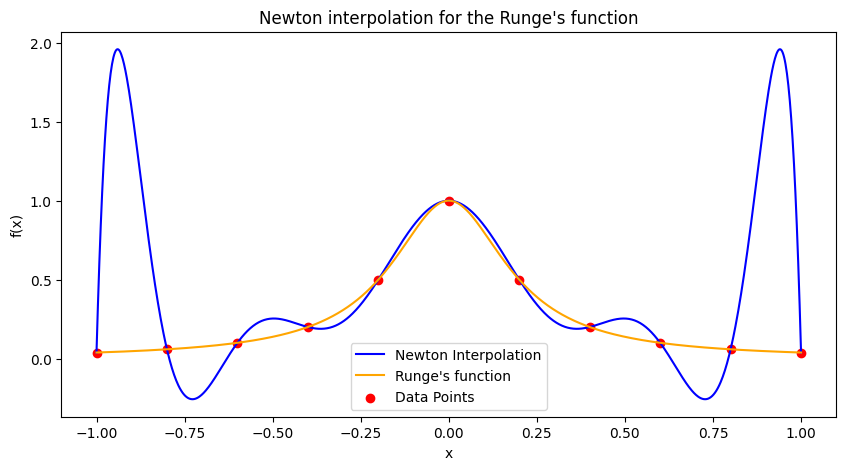

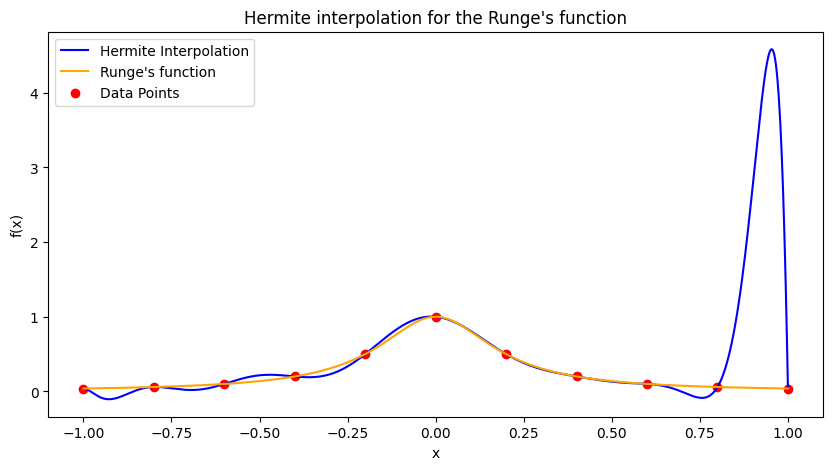

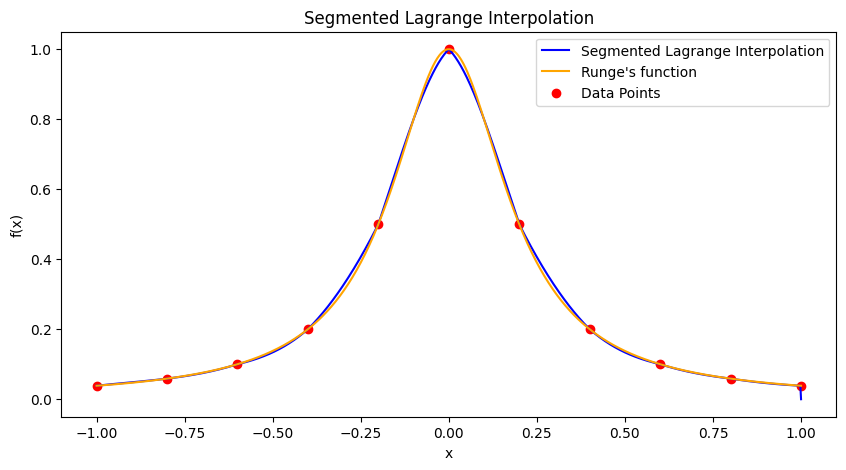

In [29]:
y=sp.symbols('y')
f_R=1/(1+25*x**2)
f_R_dif=sp.lambdify(x,sp.diff(f_R,x))
f_R=sp.lambdify(x,f_R)


a=-1
b=1

z=np.linspace(a,b,1000)
nodes=np.linspace(a,b,11)
values=f_R(nodes)

p_Newt,_,_=newton(z,nodes,values)

p_seg=lagrangesegmentario(nodes, values, 1, z)


nodes_diff=np.concatenate([nodes[0:2],nodes[7:9]])
values_dif=f_R_dif(nodes_diff)
nodes_Herm=np.concatenate([nodes, nodes_diff])
values_Herm=np.concatenate([values, values_dif])

p_Herm,_,_=newton(z,nodes_Herm,values_Herm)



plt.figure(figsize=(10,5))
plt.plot(z,p_Newt, label='Newton Interpolation', color='blue')
plt.plot(z,f_R(z),label='Runge\'s function', color='orange')
plt.scatter(nodes, values, color='red', label='Data Points')
plt.title('Newton interpolation for the Runge\'s function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(z,p_Herm, label='Hermite Interpolation', color='blue')
plt.plot(z,f_R(z),label='Runge\'s function', color='orange')
plt.scatter(nodes, values, color='red', label='Data Points')
plt.title('Hermite interpolation for the Runge\'s function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(z,p_seg, label='Segmented Lagrange Interpolation', color='blue')
plt.plot(z,f_R(z),label='Runge\'s function', color='orange')
plt.scatter(nodes, values, color='red', label='Data Points')
plt.title('Segmented Lagrange Interpolation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()





We can note that in figure 1 and 2 the Runge effect is so obvious. We are using derivative data so the left side is different to the right side and we can observe the effect of having (or not) derivative data in figure 2.

On the other hand, we observe that the segmentation led to a less error since we are just sticking lagrange $\mathcal{L}_3$ polynomials (s=1).

## Cubic Spline Interpolation

The next interpolation we are going to study is the cubic spline interpolation. This curve is also piecewise and it is defined by cubic polynomials, ensuring that both the function and its first and second derivatives are continuous.

#### System of Equations

Let the data be $\{(x_i, f_i)\}_{i=0}^n$ the cubic spline interpolation constructs a cubic polynomial between each pair of points:

$$
S_i(x) = a_i(x - x_i)^3 + b_i(x - x_i)^2 + c_i(x - x_i) + d_i \qquad i \in \{1,...,n\}
$$

For each segment $ [x_i, x_{i+1}] $, we need to determine the coefficients $a_i$, $b_i$, $c_i$, and $d_i$, which means that we will have $3(n-1)$ variables to determine.

#### Continuity Conditions
1. **Continuity of the spline**: The spline function must be continuous at each data point.
   
   $$
   S_i(x_i) = y_i \quad \forall i = 0, 1, ..., n-1
   $$

2. **Continuity of the first derivative**: The first derivative of the spline must be continuous at each data point:
   
   $$
   S_i'(x_i) = S_{i-1}'(x_i) \quad \forall  i = 1, 2, ..., n-1
   $$

3. **Continuity of the second derivative**: The second derivative of the spline must be continuous at each data point:
   
   $$
   S_i''(x_i) = S_{i-1}''(x_i) \quad \forall  i = 1, 2, ..., n-1
   $$

4. **Boundary Conditions**: 
   - **Natural boundary conditions**: As we will be dealing just with natural splines. Then:
     
     \[
     S_0''(x_0) = 0, \quad S_{n-1}''(x_n) = 0
     \]
   

#### System Matrix for Second Derivatives

To solve for the second derivatives $ c_0, c_1, ..., c_n$, we use the following tridiagonal system:

$$
\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 \\
h_0 & 2(h_0 + h_1) & h_1 & \cdots & 0 \\
0 & h_1 & 2(h_1 + h_2) & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & \cdots & 0 & h_{n-2} & 2(h_{n-2} + h_{n-1}) \\
0 & 0 & 0 & \cdots & 1
\end{pmatrix}
\cdot
\begin{pmatrix}
c_0 \\
c_1 \\
c_2 \\
\vdots \\
c_{n-1} \\
c_n
\end{pmatrix}
=
\begin{pmatrix}
0 \\
\alpha_1 \\
\alpha_2 \\
\vdots \\
\alpha_{n-2} \\
0
\end{pmatrix}
$$

Where:
- $ h_i = x_{i+1} - x_i $
- $ \alpha_i $ are the computed values based on the second derivatives continuity at the points:
  $$
  \alpha_i = \frac{3}{h_i} \left( \frac{y_{i+1} - y_i}{h_i} - \frac{y_i - y_{i-1}}{h_{i-1}} \right)
  $$

#### Final Interpolation Equation

After solving for the second derivatives $c_i$, the coefficients $a_i$, $b_i$, and $d_i$ are calculated:
- $a_i = y_i$
- $b_i = \frac{y_{i+1} - y_i}{h_i} - h_i \left( 2c_i + c_{i+1} \right) / 3$
- $d_i = \frac{c_{i+1} - c_i}{3h_i}$

**Note that the matrix shown before is non-singular since it is tridiagonal with nonzeros rows or columns $\implies$ eigenvector and eigenvalue are nonzero**


In [30]:
### Input:
    # x: Interpolation nodes
    # y: Interpolation values
    # eval_points: Array of points at which to evaluate the spline

### Output:
    # splines: [a, b, c, d] coefficients for each segment
    # evaluated_values: List of evaluated values at the given eval_points

def cubic_spline(x, y, eval_points):
    n = len(x)
    # Step 1: Set up the system for second derivatives
    h = np.diff(x)
    l = np.ones(n)
    mu = np.zeros(n)
    z = np.zeros(n)
    
    # Boundary conditions for natural splines
    l[0] = 1
    mu[0] = 0
    z[0] = 0
    l[n - 1] = 1
    z[n - 1] = 0
    
    # Step 2: Solve for second derivatives
    for i in range(1, n - 1):
        l[i] = 2 * (x[i + 1] - x[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i]
        z[i] = (3 * (y[i + 1] - y[i]) / h[i] - 3 * (y[i] - y[i - 1]) / h[i - 1]) / l[i]

    # Step 3: Back-substitute to find second derivatives
    c = np.zeros(n)
    b = np.zeros(n - 1)
    d = np.zeros(n - 1)
    a = y[:-1]
    
    c[n - 1] = z[n - 1]
    for i in range(n - 2, -1, -1):
        c[i] = z[i] - mu[i] * c[i + 1]
        b[i] = (y[i + 1] - y[i]) / h[i] - h[i] * (c[i + 1] + 2 * c[i]) / 3
        d[i] = (c[i + 1] - c[i]) / (3 * h[i])
    
    # Store spline coefficients in a list
    splines = [(a[i], b[i], c[i], d[i]) for i in range(n - 1)]
    
    # Step 4: Evaluate the spline at the given eval_points
    evaluated_values = []
    for eval in eval_points:
        # Find the appropriate spline segment
        for i in range(n - 1):
            if x[i] <= eval <= x[i + 1]:
                dx = eval - x[i]
                spline_value = a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
                evaluated_values.append(spline_value)
                break
    
    return  evaluated_values, splines

**The splines' advantage is that with much less data (and without derivative data) we can obtain the same precission as Hermite's. Let's compare both of them.**
We will be using:$$f(x)=\text{sin}(\text{e}^x)$$

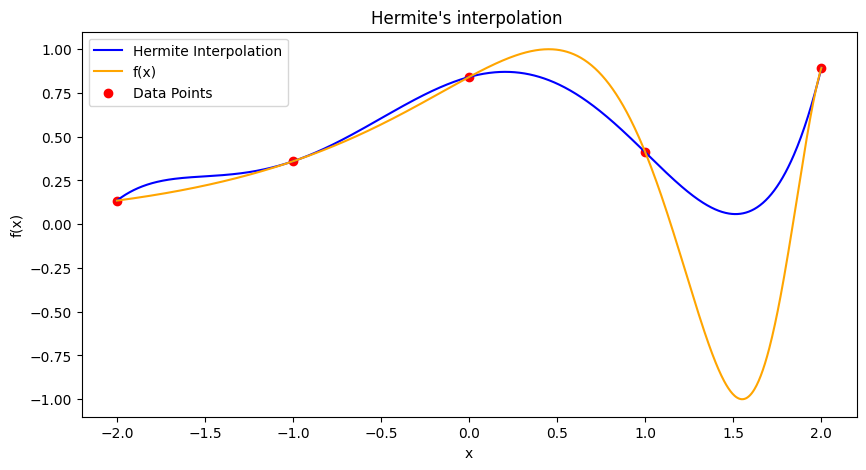

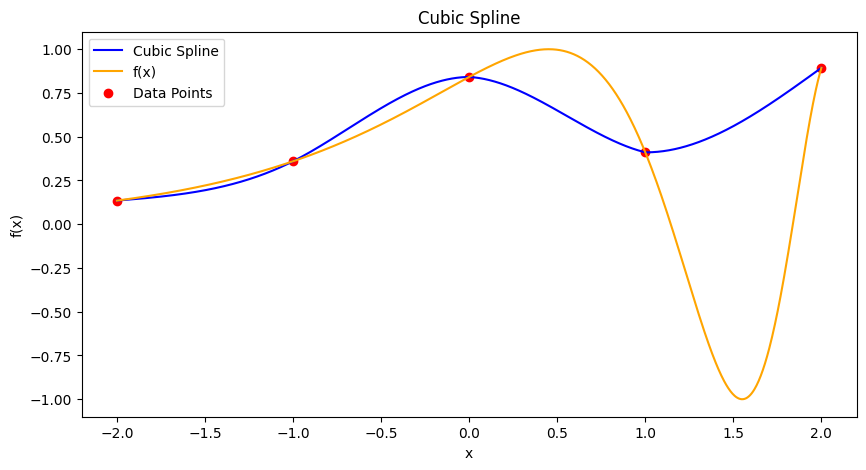

In [31]:
x = sp.symbols('x')
f = sp.sin(sp.exp(x))

f_deriv = sp.lambdify(x, sp.diff(f, x))
f = sp.lambdify(x, f)

# Interpolating nodes
a = -2
b = 2
puntos = np.linspace(a, b, 5)
valores = np.array(f(puntos))
valores_dif = np.array(f_deriv(puntos[1:2]))

#lists for Hermite interpolation
puntos_dif = np.concatenate([puntos, puntos[1:2]])
valores_dif = np.concatenate([valores, valores_dif])

z=np.linspace(a,b,1000)
pol_Hermite,_,_=newton(z,puntos_dif,valores_dif)
spline_eval,_=cubic_spline(puntos, valores,z)


plt.figure(figsize=(10, 5))
plt.plot(z,pol_Hermite, label='Hermite Interpolation', color='blue')
plt.plot(z,f(z),label='f(x)', color='orange')
plt.scatter(puntos, valores, color='red', label='Data Points')
plt.title('Hermite\'s interpolation ')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(z,spline_eval, label='Cubic Spline', color='blue')
plt.plot(z,f(z),label='f(x)', color='orange')
plt.scatter(puntos, valores, color='red', label='Data Points')
plt.title('Cubic Spline')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()



We can observe that in figure 1 we have 5 data points (4 f-values+ 1 f'-value) and we obtain similar results with just 4 f-values using cubic splines

## Extra: Universal Approximation Theorem.

This is not seen in class Numerical Approximation (23/24) in the Unviersitat de València, but I find it interesting so let's deepend in it.

There are 2 kinds of Universal Approximation Theorem:
1. **Arbitrary-width case**:
Let $ C(X, \mathbb{R}^m) $ denote the set of continuous functions from a subset $ X $ of a Euclidean $ \mathbb{R}^n $ space to a Euclidean space $ \mathbb{R}^m $. Let $ \sigma \in C(\mathbb{R}, \mathbb{R}) $. Note that 
$
(\sigma \circ x)_i = \sigma(x_i),
$
so $ \sigma \circ x$ denotes $ \sigma $ applied to each component of $ x $.

Then $ \sigma $ is not polynomial if and only if for every $ n \in \mathbb{N} $, $ m \in \mathbb{N} $, compact $ K \subseteq \mathbb{R}^n $, $ f \in C(K, \mathbb{R}^m) $, $ \varepsilon > 0 $, there exist $ k \in \mathbb{N} $, $ A \in \mathbb{R}^{k \times n} $, $ b \in \mathbb{R}^k $, $ C \in \mathbb{R}^{m \times k} $ such that
$$
\sup_{x \in K} \| f(x) - g(x) \| < \varepsilon,
$$
where 
$$
g(x) = C \cdot (\sigma \circ (A \cdot x + b)).
$$

This means that the space of feedforward networks (unidirectional neurons) with non-polynomial function are dense in the space of the continuous function in a compact subset of an Euclidian space.

2. **Arbitrary-depth case. (L1 distance, ReLU activation, arbitrary depth, minimal width):**

For any Bochner--Lebesgue $p$-integrable function
$$
f: \mathbb{R}^n \to \mathbb{R}^m,
$$
and any $ \varepsilon > 0 $, there exists a fully connected ReLU network $ F $ of width exactly
$$
d_m = \max\{n+1, m\},
$$
satisfying
$$
\int_{\mathbb{R}^n} \| f(x) - F(x) \|^p \, dx < \varepsilon.
$$

3. **Additional details**. There are more details on both cases in order to bound the number of neurons in case 1 or the number of layers in case 2. 

#### **We will be applying just the first case, Arbitrary-width case.**
Since the statement of the theorem is that for a given function $f$ there exists a sequence of neurons $\{\phi_n \}_n$ such $\phi_n \rightarrow f$ when $n \rightarrow \infty$ we can decide the maximum error our network will make and then create the neurons needed to achieve that bound. \\

It's time now to implement this. We will:
- Define function to create data sets based on our functions.
- Create NN.
- Define the model/ training result.

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_data(a, b, points, f):  # [a, b] interval with a numeric function f
    X = np.linspace(a, b, points)
    Y = f(X)
    return torch.tensor(X, dtype=torch.float32).view(-1, 1), torch.tensor(Y, dtype=torch.float32).view(-1, 1)  # giving tensor format (column vector) in order to work with


activation_functions = {
    'relu': nn.ReLU(),
    'tanh': nn.Tanh(),
    'sigmoid': nn.Sigmoid()
}


class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn='relu'):  # basis of the NN with 3 layers (input, hidden, output)
        super(NeuralNetwork, self).__init__()

        self.activation = activation_functions.get(activation_fn, nn.ReLU())  # Select activation function

        self.hidden = nn.Linear(input_dim, hidden_dim)  # mapping (linearly) input to hidden
        self.output = nn.Linear(hidden_dim, output_dim)  # mapping (linearly) hidden to output

    def forward(self, x):  # takes input and goes forward through the layers until the output
        x = self.hidden(x)  # Pass through the hidden layer
        x = self.activation(x)  # Apply the selected activation function
        x = self.output(x)  # Output layer
        return x


def train_network(a, b, points, f, target_error, activation_fn='relu', max_epochs=10000, initial_hidden_dim=10, learning_rate=0.001):
    # Generating the training data
    X_train, Y_train = generate_data(a, b, points, f)
    
    input_dim = 1  # just 1 x value 
    output_dim = 1  # just 1 f value (scalar functions)
    hidden_dim = initial_hidden_dim
    
    epoch = 0
    while epoch < max_epochs:
        # Now passing the activation_fn parameter to the NeuralNetwork constructor
        model = NeuralNetwork(input_dim, hidden_dim, output_dim, activation_fn=activation_fn)  
        criterion = nn.MSELoss()  # Mean square error as loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer is recommended
        
        model.train() 
        for epoch_num in range(max_epochs):
            Y_pred = model(X_train)
            loss = criterion(Y_pred, Y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch_num + 1) % 500 == 0:
                print(f'Epoch [{epoch_num+1}/{max_epochs}], Loss: {loss.item():.4f}')
            
            if loss.item() < target_error:
                print(f"Error reached ({loss.item():.4f}) with {hidden_dim} neurons")
                return model, loss.item(), hidden_dim
        
        hidden_dim += 5  # each time the bound is not over, we add 5 neurons more 
        print(f"Increasing neurons. Now we have: {hidden_dim} neurons")
        
        epoch += 1  # Increment epoch counter

    return model, loss.item(), hidden_dim


Epoch [500/10000], Loss: 0.0826
Epoch [1000/10000], Loss: 0.0163
Epoch [1500/10000], Loss: 0.0122
Epoch [2000/10000], Loss: 0.0099
Epoch [2500/10000], Loss: 0.0083
Epoch [3000/10000], Loss: 0.0069
Epoch [3500/10000], Loss: 0.0058
Epoch [4000/10000], Loss: 0.0047
Epoch [4500/10000], Loss: 0.0038
Epoch [5000/10000], Loss: 0.0031
Epoch [5500/10000], Loss: 0.0025
Epoch [6000/10000], Loss: 0.0020
Epoch [6500/10000], Loss: 0.0017
Epoch [7000/10000], Loss: 0.0015
Epoch [7500/10000], Loss: 0.0013
Epoch [8000/10000], Loss: 0.0012
Epoch [8500/10000], Loss: 0.0012
Epoch [9000/10000], Loss: 0.0011
Epoch [9500/10000], Loss: 0.0010
Error reached (0.0010) with 10 neurons


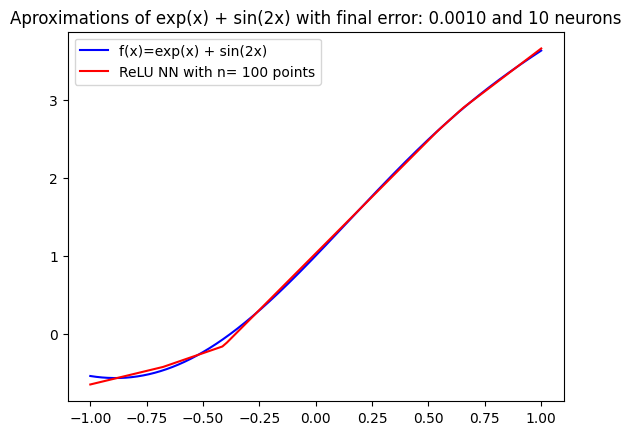

In [33]:

# Desired function f (Custom)
def f(x):
    return np.exp(x) + np.sin(2*x)

target_error = 0.001  # Maximum desired error
a = -1
b = 1
n_points=100
points_graph=np.linspace(a,b,1000)


model_ReLU, final_error, neur_RELU = train_network(a, b,n_points, f, target_error)

model_ReLU.eval()
with torch.no_grad():
    X_train, Y_train = generate_data(a, b,n_points, f)
    Y_pred = model_ReLU(X_train)



plt.plot(points_graph, f(points_graph), label='f(x)=exp(x) + sin(2x)', color='blue')
plt.plot(X_train.numpy(), Y_pred.numpy(), label=f'ReLU NN with n= {n_points} points', color='red')
plt.legend()
plt.title(f"Aproximations of exp(x) + sin(2x) with final error: {final_error:.4f} and {neur_RELU} neurons")
plt.show()


#####  We could try other family of neurons, such as tanh 

Epoch [500/10000], Loss: 3.3854
Epoch [1000/10000], Loss: 2.7652
Epoch [1500/10000], Loss: 2.2596
Epoch [2000/10000], Loss: 1.8146
Epoch [2500/10000], Loss: 1.4186
Epoch [3000/10000], Loss: 1.0840
Epoch [3500/10000], Loss: 0.8044
Epoch [4000/10000], Loss: 0.5708
Epoch [4500/10000], Loss: 0.3809
Epoch [5000/10000], Loss: 0.2365
Epoch [5500/10000], Loss: 0.1386
Epoch [6000/10000], Loss: 0.0819
Epoch [6500/10000], Loss: 0.0544
Epoch [7000/10000], Loss: 0.0419
Epoch [7500/10000], Loss: 0.0345
Epoch [8000/10000], Loss: 0.0284
Epoch [8500/10000], Loss: 0.0228
Epoch [9000/10000], Loss: 0.0178
Epoch [9500/10000], Loss: 0.0135
Epoch [10000/10000], Loss: 0.0099
Increasing neurons. Now we have: 15 neurons
Epoch [500/10000], Loss: 2.2905
Epoch [1000/10000], Loss: 1.6277
Epoch [1500/10000], Loss: 1.1480
Epoch [2000/10000], Loss: 0.7887
Epoch [2500/10000], Loss: 0.5160
Epoch [3000/10000], Loss: 0.3139
Epoch [3500/10000], Loss: 0.1785
Epoch [4000/10000], Loss: 0.1027
Epoch [4500/10000], Loss: 0.0686


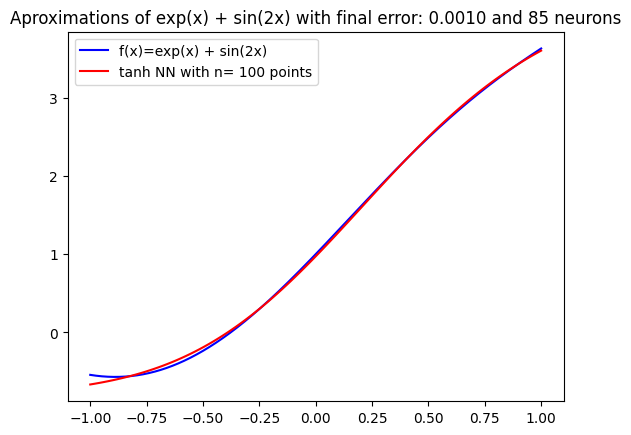

In [34]:
model_Tanh, final_error,dim_tanh = train_network(a, b,n_points, f, target_error,activation_fn='tanh',max_epochs=10000, initial_hidden_dim=10, learning_rate=0.0001)

model_Tanh.eval()
with torch.no_grad():
    X_train, Y_train = generate_data(a, b,n_points, f)
    Y_pred = model_Tanh(X_train)


plt.plot(points_graph, f(points_graph), label='f(x)=exp(x) + sin(2x)', color='blue')
plt.plot(X_train.numpy(), Y_pred.numpy(), label=f'tanh NN with n= {n_points} points', color='red')
plt.legend()
plt.title(f"Aproximations of exp(x) + sin(2x) with final error: {final_error:.4f} and {dim_tanh} neurons")
plt.show()

It is important to notice that in this task the ReLU activation function works better than the tanh since we needed 80 less neurons and 45 less seconds to train our model. But at the end, we obtained similar final functions.

# Thank you for reading! Glad for any advice you can give me! 
Contact me https://www.linkedin.com/in/javier-rodr%C3%ADguez-jim%C3%A9nez/